# Sine Wave

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

## 1. Let's create a sine wave

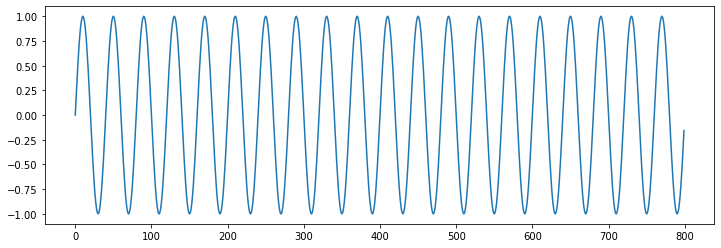

In [2]:
#let t = 1 to 800
# f / 40
f = 40
t = torch.linspace(0,799, steps=800)
y = torch.sin(2*torch.pi*t / f) #2*pi*t / f

plt.figure(figsize=(12,4))
plt.plot(y)

In [3]:
y[0] #later on, in the neural networrk , we need to reshape
#this the X1 we are talking about

tensor(0.)

In [4]:
y.shape #later on, we need to reshape to (Length, Bacth, Features) -- > (L, B, Hin) 
        #is the same as (L, N, Hin)
        #(800, 1, 1)

torch.Size([800])

In [5]:
#example of the series with two features
'''
Country: Thailand
    egg price   gold price  oil price
t0  
t1
t2
t3

Country: Nepal
Country: Vietnam
'''

'''
Stock : Apple
    close price open price
t0
t1
t2

Stock : Google
'''

'\nStock : Apple\n    close price open price\nt0\nt1\nt2\n\nStock : Google\n'

In [6]:
#i gonna create train set and test set
#in time series, test set ALWAYS THE FUTURE of train set
#you can, but not with the typical RNN, because typical RNN look forward
#you need to do bidirectional, or only backward direction

test_size = 40

train_set = y[:-test_size]
test_set  = y[-test_size:] #40 ahead of train!

In [7]:
train_set.shape

torch.Size([760])

In [8]:
#we want to create real sample
#maybe we want to use 5 data before to predict the next 3
#we call 5 as window size, and 3 as the label size

def input_data(seq, window_size,label_size=1):
    out = []
    total_length = len(seq)
    for i in range(total_length-window_size): #if not, we will go out of bound
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+label_size]
        out.append((window,label))
    return out
#question: if my window is 3, label size is 1, my seq is 760
#        : then what is the shape of out

In [9]:
window_size = 40
train_data = input_data(train_set,window_size)

len(train_data) #720 = 760 - 40 #(L, B, Hin) = (40,720,1)

720

In [10]:
torch.set_printoptions(sci_mode=False)
sample = train_data[0][0] #40 days before target
target = train_data[0][1] #41 the day after the sample

sample, target

## 2. Let's create a LSTM model
LSTM is basically RNN wich address long-term dependencies

## Let's learn LSTM

In [11]:
input_size = 1 #same as input features
hidden_size = 50 #same as output features
lstm = nn.LSTM(input_size,hidden_size,num_layers= 2)

In [12]:
seq, target = train_data[0]

In [13]:
seq.shape
#so if we want to input to LSTM, we must reshape to (L,  N, Hin)
#                                                   (40, 1, 1)

torch.Size([40])

In [14]:
# out = lstm(seq) #error, because pytorch need (L,N,Hin)

In [15]:
seq = seq.reshape(len(seq),1,-1)
seq.shape

torch.Size([40, 1, 1])

In [16]:
out, (hn,cn)= lstm(seq)
print(out.shape) #[40, 1, 50] --> (L, N, Hout) 
print(hn.shape) #[1, 1, 50] --> (D+num_layers, N, Hout) 

torch.Size([40, 1, 50])
torch.Size([2, 1, 50])


In [17]:
#so why hn now as 2???

In [18]:
assert (out[-1,:,:] == hn[1]).all() #out[-1,:,:] is the last hidden state

In [19]:
## so yay! we understand LSTM!!!! actually NOT..... but next year

## 3. Designing the neural network

In [20]:
class LSTM(nn.Module):
    #why out_size = 1, because later on, we will label_size =1
    def __init__(self,hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,out_size) #taking the last hidden state

        #optional 
        #h0, c0
        #(D*num layer, N, Hin)
        self.hidden = (torch.zeros(1, 1, hidden_size),
                       torch.zeros(1, 1, hidden_size))

    def forward(self, seq):
        #seq shape : 40 <-- already after input data
        seq = seq.reshape(len(seq),1,-1)
        out, (_,_) = self.lstm(seq, self.hidden) #you don't need self.hidden
        #out shape : (L, N, Hout * D) ==> (40, 1, 50)
        #get the last hidden state
        out = out[-1,:,:] #(B, Hout)
        #out shape : (1,50) 
        out = self.linear(out)
        #out shape : (1, 1)
        return out

## 4. Test our model

In [21]:
random_data = torch.randn(40)

In [22]:
torch.manual_seed(9999)
model = LSTM()

out = model(random_data)
out

tensor([[-0.0391]], grad_fn=<AddmmBackward0>)

## 5. Training !!!

In [23]:
criterion = nn.MSELoss() #regression
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model) #why 200?, why 10000????

   200
 10000
   200
   200
    50
     1
______
 10651


Epoch : 0 - Loss : 0.07983363419771194
Loss: 0.5973926782608032


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


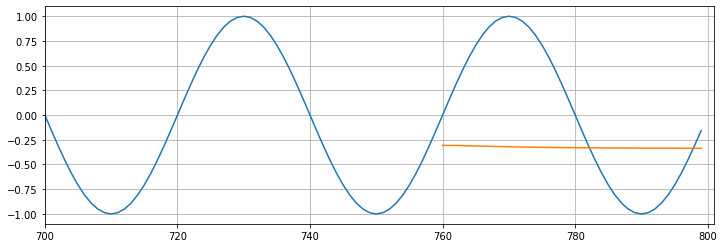

Epoch : 1 - Loss : 0.05137188360095024
Loss: 0.5454806089401245


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


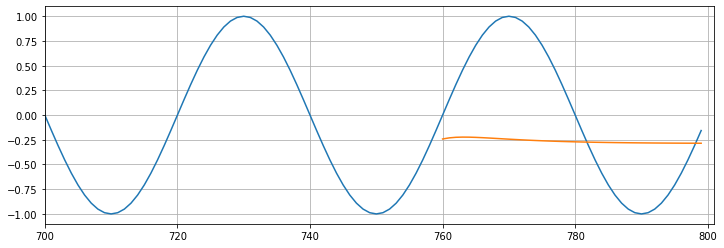

Epoch : 2 - Loss : 0.020354807376861572
Loss: 0.43525585532188416


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


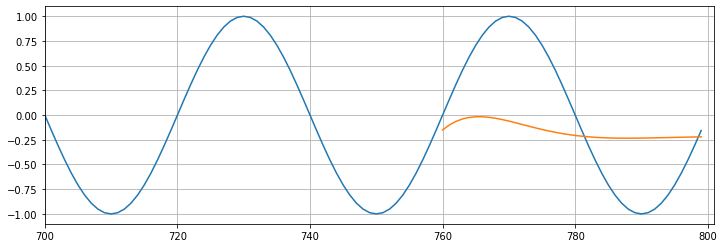

Epoch : 3 - Loss : 0.0019535901956260204
Loss: 0.13613827526569366


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


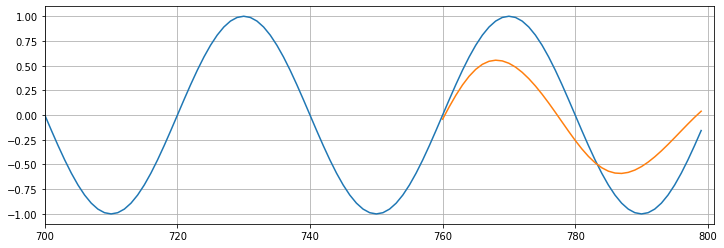

Epoch : 4 - Loss : 0.00010279908747179434
Loss: 0.00643522385507822


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


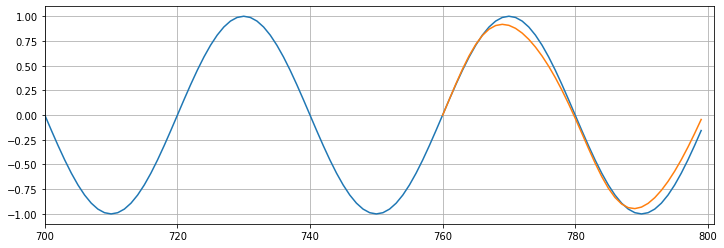

Epoch : 5 - Loss : 3.0335171686601825e-05
Loss: 0.0014656179118901491


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


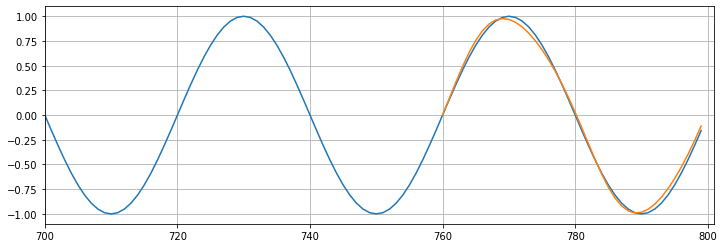

Epoch : 6 - Loss : 2.2990167053649202e-05
Loss: 0.00129690021276474


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


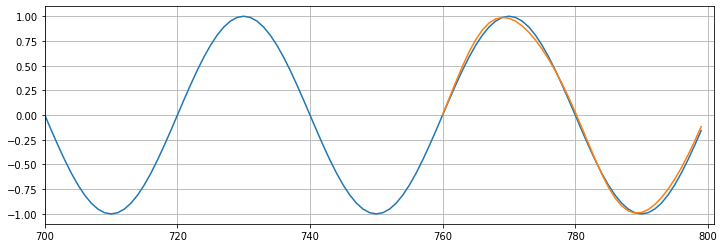

Epoch : 7 - Loss : 2.0622934243874624e-05
Loss: 0.0013170172460377216


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


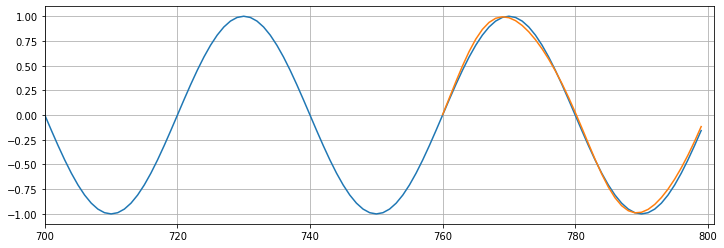

Epoch : 8 - Loss : 1.9259945474914275e-05
Loss: 0.0013592701870948076


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


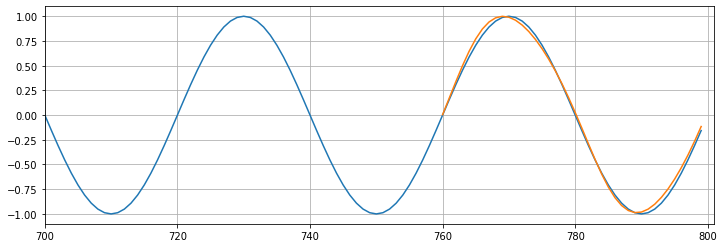

Epoch : 9 - Loss : 1.8392975107417442e-05
Loss: 0.0014058388769626617


c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Python3.10.4\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


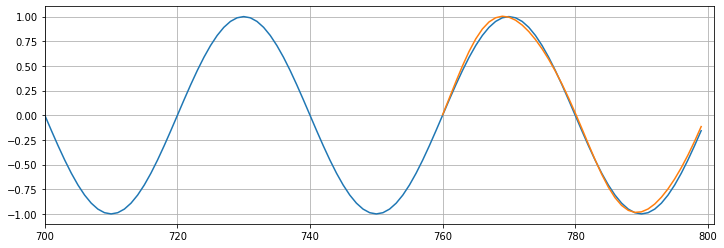

In [25]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        #seq shape : (40)
        #y_train : (1)
        # print(seq.shape)
        # print(y_train.shape)
        # break
        yhat = model(seq) #1. predict
        yhat = yhat.reshape(-1) #I think you don't need this
        # print(yhat.shape, y_train.shape)
        loss = criterion(yhat,y_train) #2. loss
        optimizer.zero_grad() #3. zero_grad
        loss.backward() #4. backward
        optimizer.step() #5. step
    
    print(f'Epoch : {i} - Loss : {loss}')
    
    
    #do the test right away here - like validation
    preds = train_set[-window_size:].tolist() #take the last 40 guys since 720-760
    # print(preds)

    for _ in range(future): #0 to 39
        seq = torch.FloatTensor(preds[-window_size:]) #empty array of size 40 #720-760
        with torch.no_grad():
            yhat = model(seq)
            preds.append(yhat) #761
    
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f'Loss: {loss}')

    # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()